In [1]:
from IPython import get_ipython
from IPython.display import display
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import string
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Package sentence tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
with open('/content/setdata.json') as content:
  data = json.load(content)

In [4]:
# Membuat DataFrame dari data JSON (mengonversi data json ke dataframe)
df = pd.DataFrame(data['intents'])

# Menampilkan DataFrame
display(df)  # Untuk tampilan yang lebih interaktif di Colab

,tag,patterns,responses,context
0,greeting,"[hallo, hello, helo, hai, haloo, halooo, halo,...","[Hai! Jiwa disini, ada yang bisa dibantu? kami...",[]
1,Jiwa,"[Apa itu Jiwa?, Apa itu Jiwa?, Siapa Jiwa?, Ji...",[Jiwa adalah aplikasi chatbot yang dibuat khus...,[]
2,bantu_Jiwa,"[kamu bisa bantu aku?, kamu bisa bantuin aku?,...","[Apa yang bisa Jiwa bantu?, Kamu butuh bantuan...",[]
3,sedang_apa,"[kamu lagi ngapain Jiwa?, lagi ngapain?, sedan...","[Jiwa sedang ngobrol dengan kamu :), Jiwa lagi...",[]
4,tanya,"[aku mau tanya, aku mau tanya boleh?, tanya, a...","[iya sahabat Jiwa, mau tanya apa?, kamu nannye...",[]
...,...,...,...,...
95,cara_penanganan_ocd,"[Cara mengatasi OCD, Bagaimana mengobati gangg...",[Penanganan OCD melibatkan berbagai pendekatan...,[]
96,stigma_dan_perasaan_bersalah,"[stigma dan perasaan bersalah, stigma dan pera...",[Stigma terhadap gangguan kesehatan mental mas...,[]
97,dukungan_gangguan_mental,"[dukungan individu, dukungan individu untuk ga...",[Dukungan bagi individu yang mengalami ganggua...,[]
98,dukungan_teman,"[dukungan teman, dukungan teman untuk gangguan...",[Dukungan dari teman adalah berarti bagi indiv...,[]


In [5]:
# Mendapatkan semua data ke dalam list
tags = [] # Data tag
inputs = [] # Data input atau pattern
responses = {} # Data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # Add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [6]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(inputs, tags,test_size=0.2, random_state=42)

# Konversi data ke dalam dataframe
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [7]:
#remove punktuation
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [8]:
train_data

,patterns,tags
0,mantap bro,pujian
1,apakah pola makan berpengaruh untuk kesehatan ...,pentingnya_pola_makan_sehat_untuk_kesehatan_me...
2,tips untuk tidur yang lebih baik,cara_mengatasi_gangguan_tidur
3,kamu bisa kan bantuin aku,bantu_Jiwa
4,bagaimana cara mengurangi risiko bunuh diri,cara_pencegahan_bunuh_diri
...,...,...
1223,apa yang dimaksud kesehatan emosional,definisi_kesehatan_emosional
1224,apa saja jenis gangguan makan,definisi_gangguan_makan
1225,meningkatkan mental health dengan cara apa,menjaga_hubungan_sosial_berpengaruh_terhadap_k...
1226,tandatanda orang dengan ocd,tanda_tanda_ocd


In [9]:
test_data

,patterns,tags
0,sebab kecemasan,penyebab_kecemasan
1,please help me,bantu_Jiwa
2,aku terbantu banget makasih ya,terimakasih
3,apa yang menyebabkan depresi,penyebab_depresi
4,pengobatan untuk gangguan tidur,obat_gangguan_tidur
...,...,...
302,ciriciri kecemasan,tanda_tanda_kecemasan
303,pola makan sehat itu penting gak si buat keseh...,pentingnya_pola_makan_sehat_untuk_kesehatan_me...
304,dukungan teman untuk orang dengan masalah kese...,dukungan_teman
305,kamu kurang bagus tau,kritik


In [10]:
# Install Sastrawi
get_ipython().system('pip install Sastrawi')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.0 MB/s eta 0:00:00


In [11]:
# Stemming using Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

train_data['patterns'] = train_data['patterns'].apply(stem_text)
test_data['patterns'] = test_data['patterns'].apply(stem_text)
train_data

,patterns,tags
0,mantap bro,pujian
1,apakah pola makan pengaruh untuk sehat mental,pentingnya_pola_makan_sehat_untuk_kesehatan_me...
2,tips untuk tidur yang lebih baik,cara_mengatasi_gangguan_tidur
3,kamu bisa kan bantuin aku,bantu_Jiwa
4,bagaimana cara kurang risiko bunuh diri,cara_pencegahan_bunuh_diri
...,...,...
1223,apa yang maksud sehat emosional,definisi_kesehatan_emosional
1224,apa saja jenis ganggu makan,definisi_gangguan_makan
1225,tingkat mental health dengan cara apa,menjaga_hubungan_sosial_berpengaruh_terhadap_k...
1226,tandatanda orang dengan ocd,tanda_tanda_ocd


In [12]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])
x_train

[[257, 199],
 [35, 71, 23, 60, 9, 4, 1],
 [95, 9, 16, 5, 116, 34],
 [21, 25, 200, 201, 8],
 [11, 6, 134, 135, 43, 33],
 [49, 1, 14, 36, 226, 2],
 [11, 6, 12, 3, 23],
 [54, 2, 178],
 [6, 202, 3, 23],
 [11, 6, 108, 71, 16, 5, 34, 167, 4, 1],
 [15, 12, 20],
 [8, 227, 2, 168, 149, 92, 39, 228, 1, 14],
 [11, 6, 10, 203, 179, 4, 1],
 [11, 19, 117, 122, 12, 72],
 [180, 25, 258, 76, 21],
 [51, 15, 93],
 [28, 153, 55, 3, 1, 35, 259, 65],
 [60, 30, 65, 47, 61, 4, 1],
 [2, 5, 73, 42, 154, 31, 13, 204, 101, 5, 52, 3, 1, 14],
 [51, 4, 74],
 [49, 4, 1, 75],
 [17, 36, 3, 4, 1, 7, 2, 181],
 [37, 123, 24, 3, 1],
 [17, 94, 20],
 [11, 37, 89, 55, 28, 47, 24, 36, 3, 1],
 [35, 32, 136, 49, 4, 1],
 [2, 7, 3, 16],
 [37, 123],
 [2, 5, 48, 19, 20],
 [56, 6, 205, 90, 109, 44],
 [2, 83, 3, 102, 38, 124, 5, 155, 77, 328],
 [150, 3, 137],
 [37, 41, 47, 24, 12, 3, 1, 7, 2],
 [96, 125],
 [37, 123, 24, 3, 1, 13, 206],
 [260, 5, 39, 21],
 [8, 126, 103, 91, 261],
 [45, 18, 38, 94],
 [15, 18],
 [18, 182, 3, 1, 14, 57],


In [13]:
# Apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)
x_train

array([[  0,   0,   0, ...,   0, 257, 199],
       [  0,   0,   0, ...,   9,   4,   1],
       [  0,   0,   0, ...,   5, 116,  34],
       ...,
       [  0,   0,   0, ...,  19,   6,   2],
       [  0,   0,   0, ...,  13,  19,  69],
       [  0,   0,   0, ..., 192,  13,  18]], dtype=int32)

In [14]:
print("Max Sequence Length:", max_sequence_length)

Max Sequence Length: 15


In [15]:
# Combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

# Encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])
y_train

array([82, 68,  8, ..., 58, 91, 92])

In [16]:
# Splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

In [27]:
# Mengubah tingkat dropout menjadi 0.5
dropout_rate = 0.5

# Mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

# Bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x) # Change return_sequences to False
x = Dropout(dropout_rate)(x)

# Output layer
num_classes = len(classes)
x = Dense(num_classes, activation="softmax")(x)
model = Model(i, x)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 100)             │          55,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           6,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,948 (374.80 KB)

 Trainable params: 95,948 (374.80 KB)

 Non-trainable params: 0 (0.00 B)

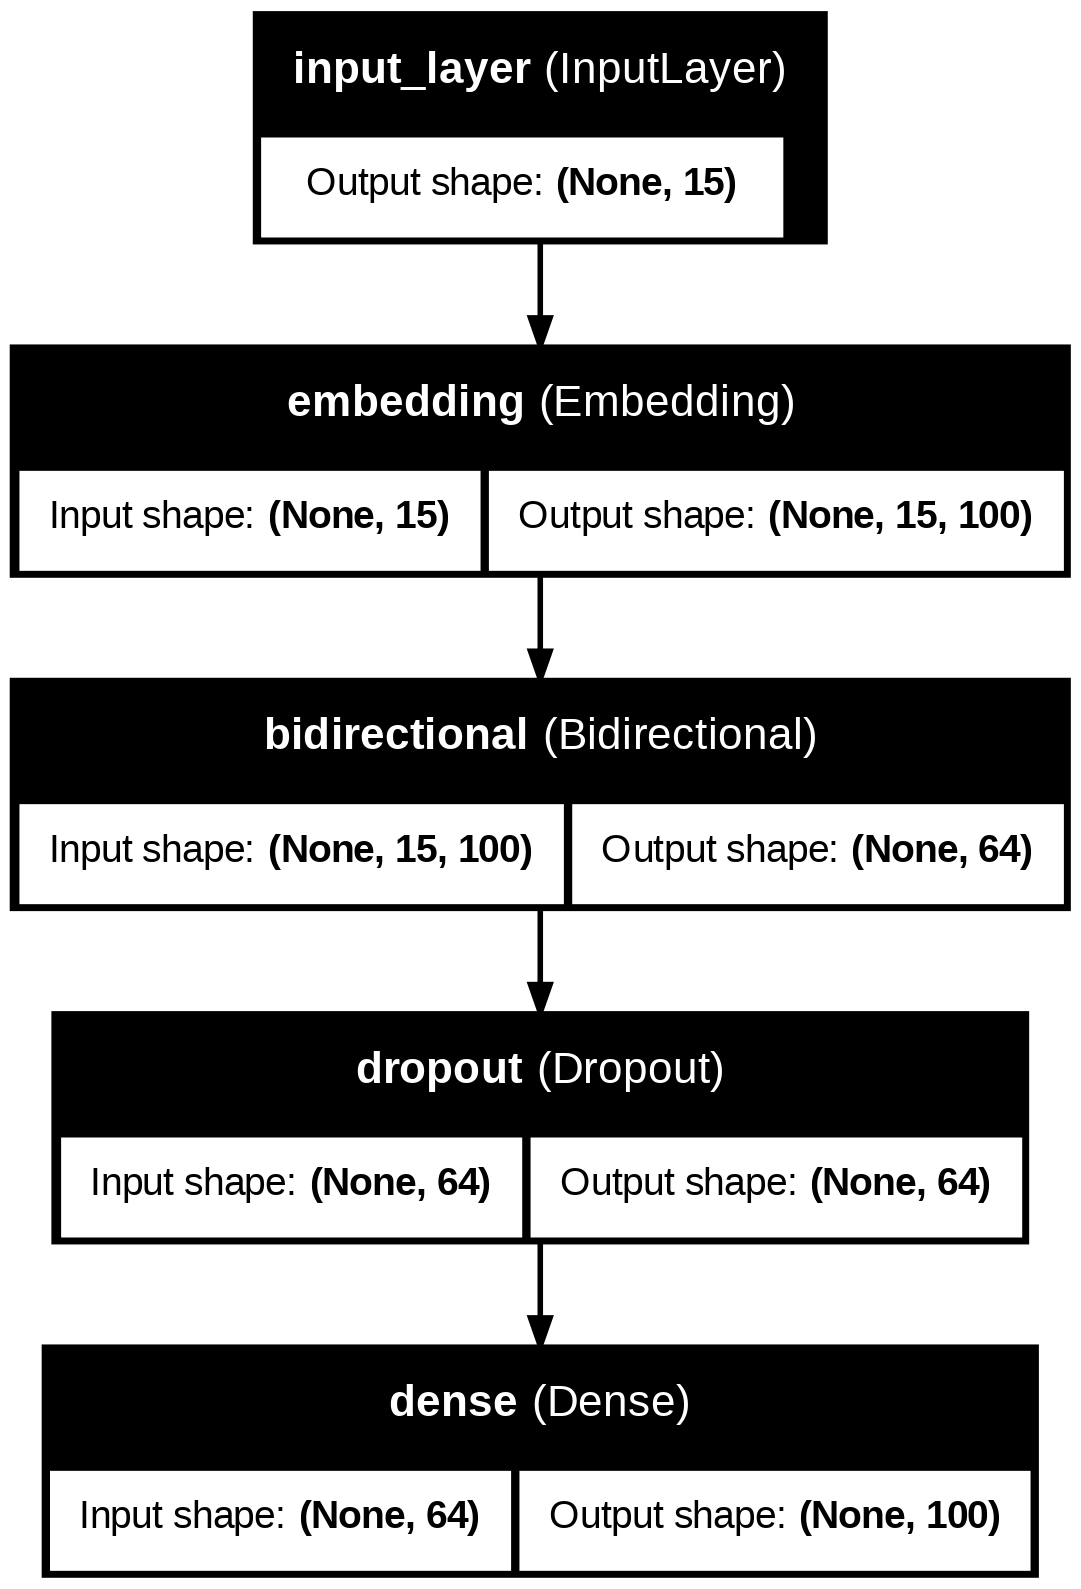

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [28]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Instantiate the callback class
#cb = myCallback()

In [29]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [30]:
%%time
# Training the model
batch_size=16
history = model.fit(train_dataset[0], train_dataset[1], epochs=150)

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0130 - loss: 4.5983
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0151 - loss: 4.5389
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0296 - loss: 4.4096
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0419 - loss: 4.2119
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0838 - loss: 3.8764
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1373 - loss: 3.7153
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2203 - loss: 3.4027
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3122 - loss: 3.1077
Epoch 9/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3582 - loss: 2.8181
Epoch 10/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4151 - loss: 2.5785
Epoch 11/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4884 - loss: 2.2702
Epoch 12/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

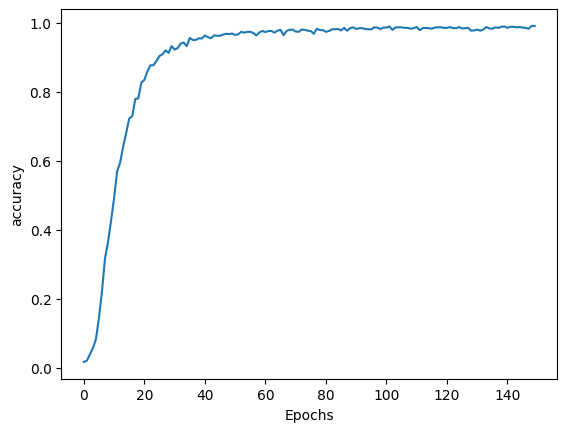

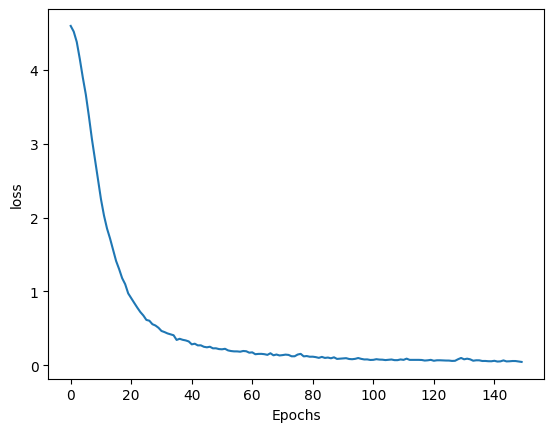

In [31]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8632
Precision: 0.9045
Recall: 0.8632
F1-score: 0.8710


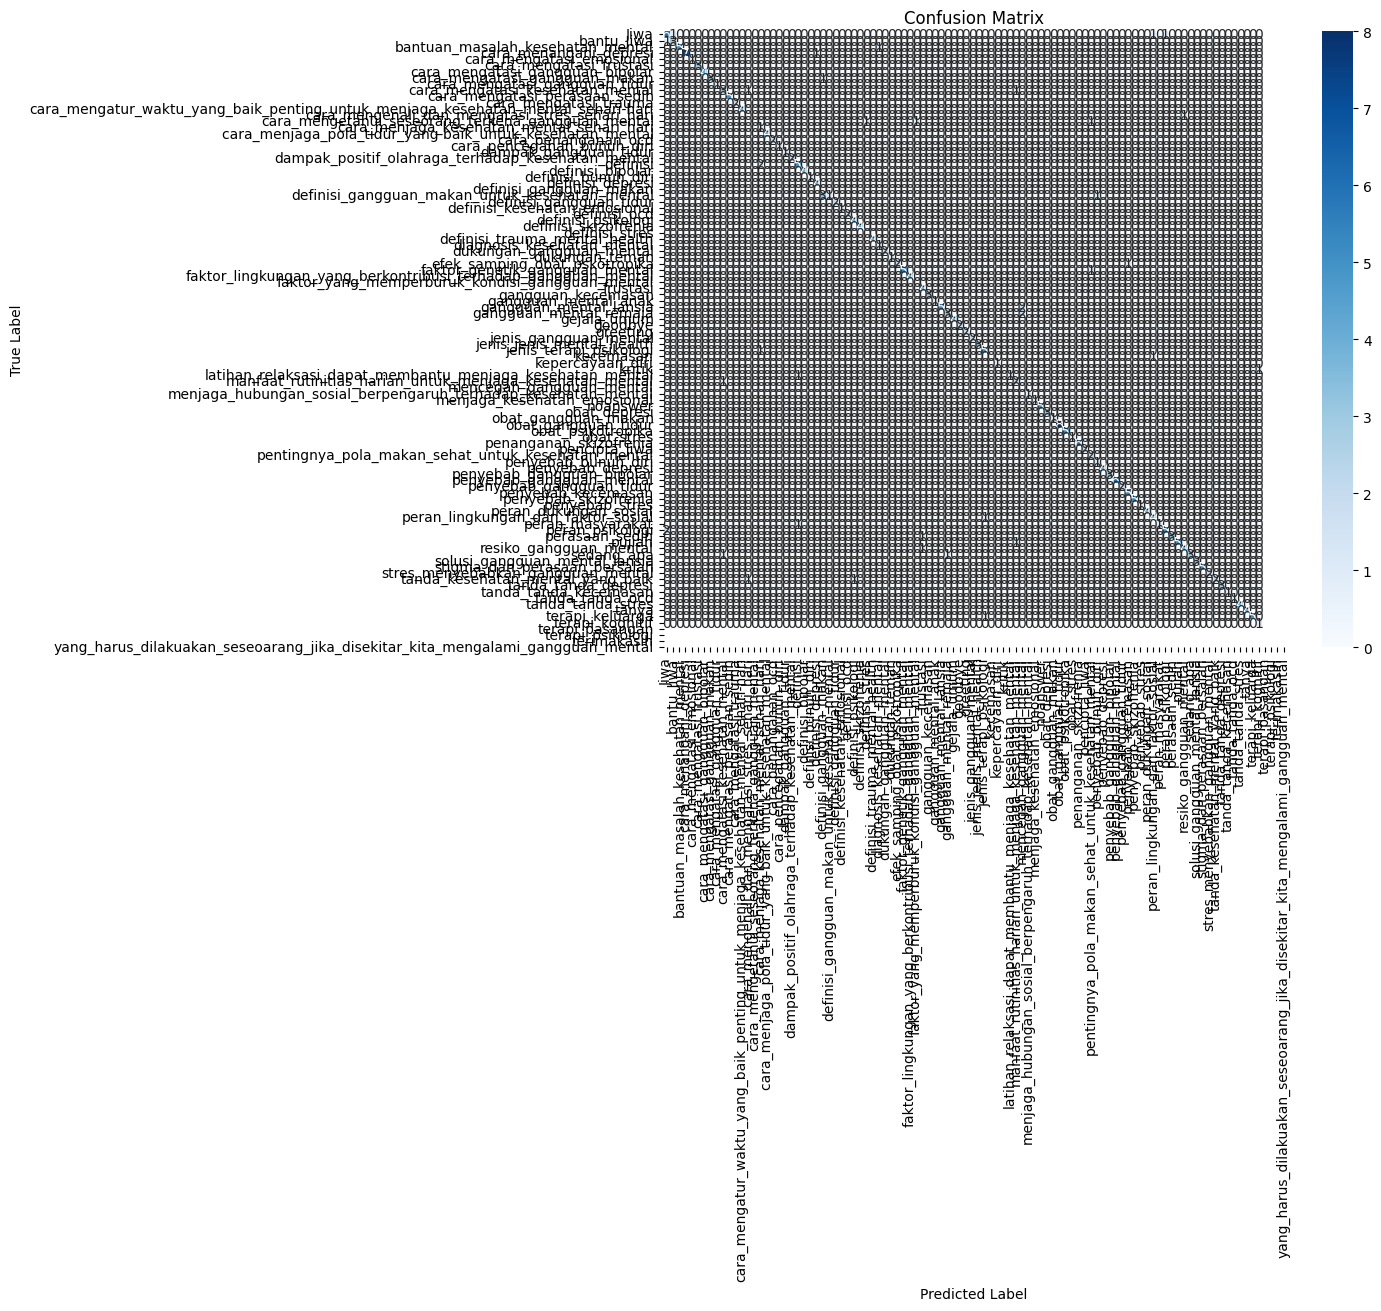

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi pada data uji
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil indeks kelas dengan probabilitas tertinggi

# 2. Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 3. Visualisasikan confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input(' Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],max_sequence_length)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print(" ChatbotX :",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

 Kamu : haiii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 ChatbotX : Maaf, saya tidak mengerti apa yang anda maksud, silahkan tulis kembali
 Kamu : haii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 ChatbotX : Saya tidak mengerti apa yang anda katakan, silahkan tuliskan kembali maksud anda !!!
 Kamu : halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
 ChatbotX : Halo! Saya Jiwa, saya akan memberikan informasi seputar kesehatan mental. Adakah yg ingin kamu tanyakan?
 Kamu : hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 ChatbotX : Halo! kami dari Jiwa, kami akan memberikan informasi seputar kesehatan mental. Adakah yg ingin kamu tanyakan?
 Kamu : halooo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 ChatbotX : Haii, Jiwa disini ya, perlu bantuan apa nih? kami akan memberikan informasi seputar kesehatan mental. Adakah yg ingin kamu tanyakan?
 Kamu : cara mengatasi sering cemas gimana?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 ChatbotX : Tanda-tanda umum kecemasan meliputi perubahan suasana hati, kegelisahan, ketegangan o

SAVE MODEL

In [34]:
# Save the model
model.save('model.h5')

In [35]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Save the max_sequence_length
with open('max_sequence_length.pkl', 'wb') as file:
    pickle.dump(max_sequence_length, file)

# Save the le
with open('le.pkl', 'wb') as file:
    pickle.dump(le, file)

# Save the responses
with open('responses.pkl', 'wb') as file:
    pickle.dump(responses, file)